# Midterm 3 Assignment 1 Davide Amadei

## Imports

In [1]:
import numpy as np
from typing import Iterator
import os

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision imports
import torchvision
from torchvision import datasets, transforms

# plot imports
from matplotlib import pyplot as plt

Use GPU if available, CPU otherwise

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utility functions

Various plotting functions used during experiments

In [3]:
def plot_comparison(data_list: list[torch.tensor], label_list: list[str],
                indices: list[int], figsize: tuple[float, float] = None) -> None:
    """simple function to plot comparisons between original images 
       and the ones reconstructed by the autoencoder

    Parameters
    ----------
    data_list : list[torch.tensor]
        list of data to show
    label_list : list[str]
        labels to use for the images
    indices : list[int]
        indices of images to show
    figsize : tuple[float, float], optional
        size of the image to be shown. If None use (len(data_list)*1.5, 3) as size, by default None
    """
    if figsize is None:
        figsize = (len(data_list)*1.5, 3)

    fig, axes = plt.subplots(len(indices), len(data_list), figsize=figsize)

    if len(indices) == 1:
        for j, data in enumerate(data_list):
            ax = axes[j]
            ax.axis("off")
            ax.set_title(f"{label_list[j]}")
            ax.imshow(data[indices[0]], cmap="gray")
        plt.show()
        return

    for i, index in enumerate(indices):
        for j, data in enumerate(data_list):
            ax = axes[i, j]
            ax.axis("off")
            if i == 0:
                ax.set_title(f"{label_list[j]}")
            ax.imshow(data[index], cmap="gray")
        
    plt.show()

In [4]:
def plot_list(indices: list[int], data:torch.tensor, labels: list[str] = None,
              figsize:tuple[float, float]=None) -> None:
    """simple function to plot a list of images

    Parameters
    ----------
    indices : list[int]
        list of indices of the data to be shown
    og : torch.tensor
        data containing images to show
    labels : list[str]
        labels of the images to plot
    figsize : tuple[float, float], optional
        size of the image to be shown. If None use (len(indices)*1.5, 3) as size, by default None
    """
    if figsize is None:
        figsize = (len(indices)*1.5, 3)

    fig, axes = plt.subplots(1, len(indices), figsize=figsize)

    for i, index in enumerate(indices):
        ax = axes[i]
        ax.axis("off")
        if labels is not None:
          ax.set_title(labels[i])
        ax.imshow(data[index], cmap="gray")

    plt.show()

In [5]:
def plot_loss(training_loss: list, validation_loss:list, title: str) -> None:
    """function to plot the loss over the epochs

    Parameters
    ----------
    training_loss : list
        list of loss values for training data
    validation_loss : list
        list of loss values for validation data
    title : str
        title to use for the plot
    """
    fig, ax = plt.subplots()
    ax.plot(training_loss, color='blue', label='Training')
    ax.plot(validation_loss, color='orange', label='Validation')
    ax.legend(loc='upper right')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')
    ax.set_title(title)
    plt.show()

Iterator that returns minibatches of given data and targets.

In [6]:
def get_minibatches(
        data: torch.Tensor, targets: torch.tensor, batchsize: int
    ) -> Iterator[tuple[torch.Tensor, torch.Tensor]]:
        """Returns minibatches of given size over (x, y).

        Parameters
        ----------
        data : torch.Tensor
            data tensor
        targets : torch.Tensor
            targets tensor
        batchsize : int
            batch size of yielded minibatches

        Yields
        ------
        Iterator[tuple[torch.Tensor,torch.Tensor]]
            iterator over minibatches
        """
        if batchsize in [None, 0, -1]:
            batchsize = data.shape[0]
        size = data.shape[0]
        batchtotal, remainder = divmod(size, batchsize)
        for i in range(batchtotal):
            mini_data = data[i * batchsize : (i + 1) * batchsize]
            mini_targets = targets[i * batchsize : (i + 1) * batchsize]
            yield (mini_data, mini_targets)
        if remainder > 0:
            yield (data[batchtotal * batchsize :], targets[batchtotal * batchsize :])

Utility function to train a model.

In [7]:
def train(model: nn.Module, tr_data: torch.tensor, tr_target: torch.tensor,
          val_data: torch.tensor, val_target: torch.tensor,
          optimizer: torch.optim.Optimizer, criterion, 
          batchsize:int = 128, max_epochs:int = 20, 
          print_frequency: int = 10) -> tuple[list, list]:
  """function to train a model with the given data and parameters

  Parameters
  ----------
  model : nn.Module
      model to train
  tr_data : torch.tensor
      training data to use
  tr_target : torch.tensor
      targets of training data
  val_data : torch.tensor
      validation data to use
  val_target : torch.tensor
      targets of validation data
  optimizer : torch.optim.Optimizer
      optimizer to use
  criterion : 
      loss function to use
  batchsize : int, optional
      size of each mini batch, by default 128
  max_epochs : int, optional
      max number of epochs of training, by default 20
  print_frequency : int, optional
      how often to print current loss, by default 10

  Returns
  -------
  tuple[list, list]
      list of loss values for training data and for validation data
  """
  tr_loss_list = []
  val_loss_list = []

  for epoch in range(max_epochs):
    epoch_loss = 0.0
    model.train()

    for i, (inputs, targets) in enumerate(get_minibatches(tr_data, 
                                                        tr_target, 
                                                        batchsize)):
      # forward
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.data

    # validation
    if val_data is not None and val_target is not None:
      model.eval()
      with torch.no_grad():
        val_preds = model(val_data)
        val_loss = criterion(val_preds, val_target)
        val_loss_list.append(val_loss.cpu())
      
      if (epoch+1) % print_frequency == 0:
        print(f"[{epoch + 1}]" 
              f" Loss: {epoch_loss / (i+1):.5f}"
              f" Validation loss: {val_loss:.5f}")
    else:
      if (epoch+1) % print_frequency == 0:
        print(f"[{epoch + 1}]" 
              f" Loss: {epoch_loss / (i+1):.5f}")
      
    tr_loss_list.append((epoch_loss / (i+1)).cpu())
    epoch_loss = 0.0
  return tr_loss_list, val_loss_list

## Loading dataset and preprocessing

Download the MNIST dataset, both training and test set. The data is normalized to be in range [0, 1].

In [8]:
if os.path.exists("./data/MNIST/"):
  download = False
else:
  download = True

tr_mnist_dataset = datasets.MNIST("./data/MNIST/", download=download, train=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                         ]))

tr_mnist = tr_mnist_dataset.data / 255
tr_mnist_labels = tr_mnist_dataset.targets

ts_mnist_dataset = (datasets.MNIST("./data/MNIST/", download=download, train=False,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                         ])))

ts_mnist = ts_mnist_dataset.data / 255
ts_mnist_labels = ts_mnist_dataset.targets

Add noise to the images from normal distribution with given scale and keep the original images as the target output to be used in training.

In [9]:
scale = 0.3

tr_data_noisy = (tr_mnist + scale * 
                       torch.randn(tr_mnist.shape)).to(device)
tr_target = tr_mnist.to(device)

ts_data_noisy = (ts_mnist + scale * 
                       torch.randn(ts_mnist.shape)).to(device)
ts_target = ts_mnist.to(device)

Clip the data to be in range [0, 1] as the noise added to the original data brings some values outside of this range.

In [10]:
tr_data_noisy = torch.clip(tr_data_noisy, 0., 1.)
ts_data_noisy = torch.clip(ts_data_noisy, 0., 1.)

Split the training set to keep a validation set. The last third of the training set is used as validation.

In [11]:
val_split = 40000

val_data = tr_mnist[val_split:]
val_labels = tr_mnist_labels[val_split:]

val_data_noisy = tr_data_noisy[val_split:]
tr_data_noisy = tr_data_noisy[:val_split]

val_target = tr_target[val_split:]
tr_target = tr_target[:val_split]

Examples of the noisy images obtained, one for each digit.

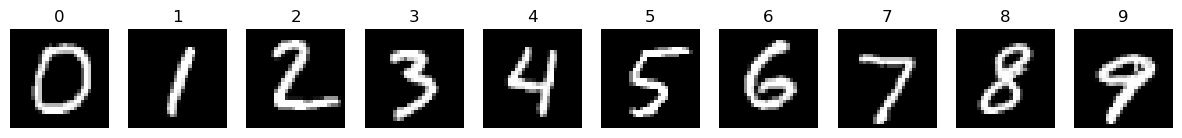

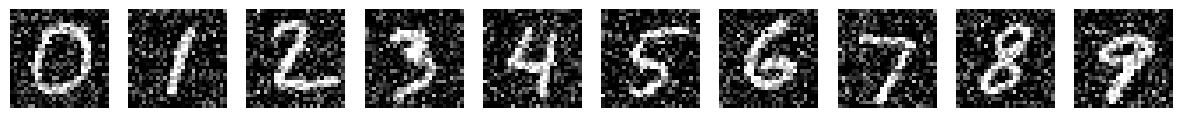

In [12]:
indices = [10, 5, 1, 30, 27, 2798, 1831, 0, 110, 9]
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

plot_list(indices, ts_mnist.cpu(), labels)
plot_list(indices, ts_data_noisy.cpu())

## Defining and training the models

Single layer denoising autoencoder, using ReLU as the activation function for the hidden layer and sigmoid for the output, so as to keep the outputs in the range [0, 1].

In [13]:
class single_layer_denoising_autoencoder(nn.Module):
  """class implementing a single layer denoising autoencoder
  """
  def __init__(self, n_units=100):
    """init function

    Parameters
    ----------
    n_units : int, optional
        number of units in the hidden layer, by default 100
    """
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, n_units),
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.Linear(n_units, 28*28),
        nn.Sigmoid(),
        nn.Unflatten(1, (28, 28))
    )
    self.apply(self._init_weights)
  
  def forward(self, x: torch.tensor) -> torch.tensor:
    """forward method of the model

    Parameters
    ----------
    x : torch.tensor
        the input data

    Returns
    -------
    torch.tensor
        the output of the net given the input
    """
    x = self.encoder(x)
    x = self.decoder(x)
    return x

  def _init_weights(self, module: nn.Module) -> None:
    """function to initialize weights and biases of a given module

    Parameters
    ----------
    module : nn.Module
        module to be initialized
    """
    if isinstance(module, nn.Linear):
      nn.init.xavier_uniform_(module.weight)
      module.bias.data.zero_()

Deep layer autoencoder with layerwise pretraining. When created the model accepts a list of integer to be used as the number of units in each encoding layer (and its corresponding decoding layer). In the final model the decoder uses a symmetric structure to the encoder, so as to decode each intermediate encoding instead of using a single decoding layer to directly get the reconstructed output from the final encoding. ReLU activation is used between each layer except for the final encoding layer, so as to not limit the encoding space to only positive values. The output instead has a sigmoid activation function as it keeps the values of the final decoding between 0 and 1, making it easy to directly use the outputs as images.<br>

For each layer the training works as follows: first, train the model as usual. When training is done, store the current encoding of the training and validation data, as they must be used as target outputs in the following training phase. Then, the add_layer method must be called, which freezes the weights of the current encoding layer, removes the current decoder, and adds the following encoding and decoding layers. <br>

When all the layers have been added, the finalize_structure method must be called, freezing the last encoding layer and building the previously described decoder. During the layerwise pretraining the weights of the decoders are also stored, so they can be optionally reused to initialize the final decoder instead of having to train it from scratch. <br>

Fine tuning of the encoder can be enabled or disabled at will by calling the fine_tuning method, which freezes or unfreezes the weights depending on the value passed to the function. <br>

The weights are always initialized using Xavier uniform initialization, while biases are initialized to 0.

In [14]:
class deep_denoising_autoencoder(nn.Module):
  """class implementing a deep denoising autoencoder where the training is done
  using layerwise pretraining of each encoding layer
  """
  def __init__(self, layers: list[int] = [500, 100], loaded: bool = False):
    """init function

    Parameters
    ----------
    layers : list[int], optional
        list of sizes for each layer, by default [500, 100]
    loaded : bool, optional
        wether the model is being reloaded from a saved checkpoint of a previously saved model.
        If True skips most initialization steps to create an empty model to be restored with
        already existing data, by default False
    """
    super().__init__()
    if not loaded:
      self.finalized = loaded
      self.current_layer = 0
      self.layers = layers
      self.encoder = nn.Sequential(
          nn.Flatten(start_dim=1),
          nn.Linear(28*28, self.layers[self.current_layer]),
          nn.ReLU()
      )
      self.decoder = nn.Sequential(
          nn.Linear(self.layers[self.current_layer], 28*28),
          nn.Sigmoid(),
          nn.Unflatten(1, (28, 28))
      )

      self.old_decoder_weights = []
      self.old_decoder_biases = []

      self.apply(self._init_weights)
    else:
      self.finalized = loaded
      self.encoder = nn.Sequential()
      self.decoder = nn.Sequential()
  
  def forward(self, x: torch.tensor) -> torch.tensor:
    """forward method of the model

    Parameters
    ----------
    x : torch.tensor
        the input data

    Returns
    -------
    torch.tensor
        the output of the net given the input
    """
    x = self.encoder(x)
    x = self.decoder(x)
    return x

  def encode(self, x: torch.tensor) -> torch.tensor:
    """function to encode the given input

    Parameters
    ----------
    x : torch.tensor
        input to be encoded

    Returns
    -------
    torch.tensor
        encoding of the input data
    """
    with torch.no_grad():
      encoding = self.encoder(x)
    return encoding

  def decode(self, x: torch.tensor) -> torch.tensor:
    """function to decode the given input

    Parameters
    ----------
    x : torch.tensor
        input to be decoded

    Returns
    -------
    torch.tensor
        decoding of the input
    """
    with torch.no_grad():
      decoded_x = self.decoder(x)
    return decoded_x

  def add_layer(self) -> None:
    """function to add the next encoding layer

    Raises
    ------
    ValueError
        when no more layers can be added or the model is being reloaded from a previous checkpoint 
    """

    if self.finalized:
      raise ValueError("Cannot add more layers, the model has already been finalized")

    # if layers were already all added or the model has been reloaded from a previous checkpoint
    # raise an error
    if self.current_layer >= len(self.layers)-1:
      raise ValueError("Cannot add more layers, the finalize_structure method must be called")
    
    with torch.no_grad():
      # freeze previous encoding layer
      index = self.current_layer * 2 + 1
      self.encoder[index].weight.requires_grad = False
      self.encoder[index].bias.requires_grad = False

      # append new encoding layer to encoder
      self.encoder.append(nn.Linear(self.layers[self.current_layer],
                                    self.layers[self.current_layer+1]))
      
      if self.current_layer != len(self.layers)-2:
        self.encoder.append(nn.ReLU())
      
      # save weights of the current decoder
      self.old_decoder_weights.append(self.decoder[0].weight)
      self.old_decoder_biases.append(self.decoder[0].bias)

      # initialize new decoder
      self.decoder = nn.Sequential(
          nn.Linear(self.layers[self.current_layer+1],
                    self.layers[self.current_layer]),
      )

      self.decoder.append(nn.ReLU())

      # initialize weights for newly added layers
      self._init_weights(self.encoder[-2])
      self._init_weights(self.decoder)

      self.current_layer += 1  

  def finalize_structure(self, reuse_weights = True) -> None:
    """method to finalize the structure of the model

    Parameters
    ----------
    reuse_weights : bool, optional
        flag determining if the weights of the decoding layers
        obtained during layerwise pretraining must be reused
        to initialize the weights in the final model, by default True

    Raises
    ------
    ValueError
    """

    if self.current_layer < len(self.layers)-1:
      raise ValueError("The model has more layers that need to be added")

    if self.finalized:
      raise ValueError("The model has already been finalized")

    with torch.no_grad():
      # freeze last encoding layer
      index = self.current_layer * 2 + 1
      self.encoder[index].weight.requires_grad = False
      self.encoder[index].bias.requires_grad = False

      # save weights of the last decoder
      self.old_decoder_weights.append(self.decoder[0].weight)
      self.old_decoder_biases.append(self.decoder[0].bias)

      # initialize new decoder
      self.decoder = nn.Sequential()

      # insert decoding layers into the decoder
      for i in range(len(self.layers)-1, 0, -1):
        decoder_layer = nn.Linear(self.layers[i],
                                  self.layers[i-1])
        
        # initialize weights with existing ones if flag is set
        if reuse_weights:
          decoder_layer.weight.copy_(self.old_decoder_weights[i])
          decoder_layer.bias.copy_(self.old_decoder_biases[i])

        self.decoder.append(decoder_layer)
        self.decoder.append(nn.ReLU())

      # insert last layer into decoder
      decoder_layer = nn.Linear(self.layers[0], (28*28))
      # initialize weights with existing ones if flag is set
      if reuse_weights:
          decoder_layer.weight.copy_(self.old_decoder_weights[0])
          decoder_layer.bias.copy_(self.old_decoder_biases[0])

      self.decoder.append(decoder_layer)
      self.decoder.append(nn.Sigmoid())
      self.decoder.append(nn.Unflatten(1, (28, 28)))   

      # initialize weights if flag is not set
      if not reuse_weights:
        self._init_weights(self.decoder)

      self.finalized = True

  def fine_tuning(self, flag: bool = True) -> None:
    """method to toggle finetuning of the encoding layers

    Parameters
    ----------
    flag : bool, optional
        flag deciding if learning for the encoding layers must be turned on, by default True
    """
    for layer in self.encoder:
      if isinstance(layer, nn.Linear):
        layer.weight.requires_grad = flag
        layer.bias.requires_grad = flag

  def _init_weights(self, module: nn.Module) -> None:
    """function to initialize weights and biases of a given module

    Parameters
    ----------
    module : nn.Module
        module to be initialized
    """
    if isinstance(module, nn.Linear):
      nn.init.xavier_uniform_(module.weight)
      module.bias.data.zero_()

Creation of the models used. All models encode the inputs in a 50 dimensional space. This was kept the same across models so that comparisons between them make more sense, allowing a better evaluation of the quality of the encoding done by the autoencoder and how well it is able to decode said encoding. The number of units in the encoding layers is of 500, 300, 100, 50, and the decoding layers use the same numbers but mirrored.<br>

In general the hyperparameters are the same for all models and the layerwise pretraining of the deep models. This is because the ones that work best seem to be the same, at least among the ones tried. A more in depth model selection would be necessary to choose more appropriate hyperparameters. <br>

Specifically, Adam was used as the optimizer, with a learning rate of 1e-4 and a weight decay of 1e-5. The batchsize used is 100 and the number of epochs of training is 200.

In [15]:
n_units = 50
layers = [500, 300, 100, 50]
batchsize = 100
n_epochs = 200
lr = 1e-4
weight_decay = 1e-5

model = single_layer_denoising_autoencoder(n_units=n_units).to(device)
deep_model = deep_denoising_autoencoder(layers=layers).to(device)

MSE is used to evaluate the autoencoders.

In [16]:
criterion = nn.MSELoss()

Training the single layer autoencoder.

In [17]:
print(model)

single_layer_denoising_autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=784, bias=True)
    (1): Sigmoid()
    (2): Unflatten(dim=1, unflattened_size=(28, 28))
  )
)


In [18]:
opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

tr_loss_list_single, val_loss_list_single = train(model,
                                                  tr_data_noisy, tr_target, 
                                                  val_data_noisy, val_target,
                                                  opt, criterion, batchsize=batchsize,
                                                  max_epochs=n_epochs)

[10] Loss: 0.03107 Validation loss: 0.03028
[20] Loss: 0.01942 Validation loss: 0.01945
[30] Loss: 0.01551 Validation loss: 0.01575
[40] Loss: 0.01375 Validation loss: 0.01406
[50] Loss: 0.01271 Validation loss: 0.01306
[60] Loss: 0.01208 Validation loss: 0.01245
[70] Loss: 0.01168 Validation loss: 0.01206
[80] Loss: 0.01141 Validation loss: 0.01180
[90] Loss: 0.01122 Validation loss: 0.01161
[100] Loss: 0.01107 Validation loss: 0.01147
[110] Loss: 0.01095 Validation loss: 0.01135
[120] Loss: 0.01087 Validation loss: 0.01127
[130] Loss: 0.01080 Validation loss: 0.01120
[140] Loss: 0.01074 Validation loss: 0.01115
[150] Loss: 0.01070 Validation loss: 0.01111
[160] Loss: 0.01066 Validation loss: 0.01107
[170] Loss: 0.01063 Validation loss: 0.01104
[180] Loss: 0.01060 Validation loss: 0.01101
[190] Loss: 0.01058 Validation loss: 0.01099
[200] Loss: 0.01056 Validation loss: 0.01097


Layerwise pretraining of the deep autoencoder.

In [19]:
# initialize the targets to be used in Training
# at the beginning this is simply the target of the input data
current_target = tr_target
current_val_target = val_target

# iterate over the layers
for i in range(len(layers)):
  print(f"Pretraining layer {i} with {layers[i]} units")
  print("This is the current model:")
  print(deep_model)

  # get new optimizer and add the parameters that must be trained
  opt = optim.Adam(deep_model.parameters(), lr=lr, weight_decay=weight_decay)
  
  # train the newly added layer
  train(deep_model, tr_data_noisy, current_target, val_data_noisy,
        current_val_target, opt, criterion, batchsize=batchsize, max_epochs=n_epochs,
        print_frequency=50)
  
  # get the curretly most recent available encoding to be used as target
  # for training the next layer
  deep_model.eval()
  with torch.no_grad():
    current_target = deep_model.encode(tr_data_noisy)
    current_val_target = deep_model.encode(val_data_noisy)

  # add a new layer to the encoder
  if i != len(layers)-1:
    deep_model.add_layer()
    deep_model.to(device)

# finalize model, reusing the stored weights for the decodding layers
deep_model.finalize_structure(reuse_weights=True)
deep_model.to(device);

Pretraining layer 0 with 500 units
This is the current model:
deep_denoising_autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=784, bias=True)
    (1): Sigmoid()
    (2): Unflatten(dim=1, unflattened_size=(28, 28))
  )
)
[50] Loss: 0.00850 Validation loss: 0.00884
[100] Loss: 0.00834 Validation loss: 0.00868
[150] Loss: 0.00830 Validation loss: 0.00865
[200] Loss: 0.00828 Validation loss: 0.00863
Pretraining layer 1 with 300 units
This is the current model:
deep_denoising_autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=300, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU

Save the deep autoencoder to later reload it in a separate object so as to keep two separate versions of the model, one using finetuning and one without using it. This is done in this way also to avoid having to do layerwise training a second time.

In [20]:
torch.save({"encoder": deep_model.encoder, "decoder": deep_model.decoder,
           "weights": deep_model.state_dict()}, "./deep.bak")

Train the deep autoencoder. The encoding layers have frozen weights, so only the decoding layers are being trained here.

In [21]:
print(deep_model)

deep_denoising_autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=300, bias=True)
    (4): ReLU()
    (5): Linear(in_features=300, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=500, bias=True)
    (5): ReLU()
    (6): Linear(in_features=500, out_features=784, bias=True)
    (7): Sigmoid()
    (8): Unflatten(dim=1, unflattened_size=(28, 28))
  )
)


In [22]:
opt = optim.Adam(deep_model.parameters(), lr=lr, weight_decay=weight_decay)

tr_loss_list_deep, val_loss_list_deep = train(deep_model,
                                              tr_data_noisy, tr_target, 
                                              val_data_noisy, val_target,
                                              opt, criterion, batchsize=batchsize,
                                              max_epochs=n_epochs)

[10] Loss: 0.00980 Validation loss: 0.01027
[20] Loss: 0.00961 Validation loss: 0.01009
[30] Loss: 0.00943 Validation loss: 0.00991
[40] Loss: 0.00923 Validation loss: 0.00973
[50] Loss: 0.00903 Validation loss: 0.00955
[60] Loss: 0.00885 Validation loss: 0.00938
[70] Loss: 0.00869 Validation loss: 0.00923
[80] Loss: 0.00855 Validation loss: 0.00910
[90] Loss: 0.00842 Validation loss: 0.00900
[100] Loss: 0.00832 Validation loss: 0.00891
[110] Loss: 0.00823 Validation loss: 0.00883
[120] Loss: 0.00815 Validation loss: 0.00876
[130] Loss: 0.00808 Validation loss: 0.00871
[140] Loss: 0.00802 Validation loss: 0.00866
[150] Loss: 0.00796 Validation loss: 0.00861
[160] Loss: 0.00791 Validation loss: 0.00858
[170] Loss: 0.00787 Validation loss: 0.00854
[180] Loss: 0.00783 Validation loss: 0.00851
[190] Loss: 0.00779 Validation loss: 0.00849
[200] Loss: 0.00776 Validation loss: 0.00846


Reload the previously saved model to be used for finetuning.

In [23]:
deep_model_ft = deep_denoising_autoencoder(layers=layers, loaded=True)
checkpoint = torch.load("./deep.bak")
deep_model_ft.encoder = checkpoint["encoder"]
deep_model_ft.decoder = checkpoint["decoder"]
deep_model_ft.load_state_dict(checkpoint["weights"])
deep_model_ft.to(device);

Enable finetuning of the encoding layers and train the model. Differently from the previous model, the encoding layers are also being trained in this case. The structure of the two models is the same.

In [24]:
print(deep_model_ft)

deep_denoising_autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=300, bias=True)
    (4): ReLU()
    (5): Linear(in_features=300, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=500, bias=True)
    (5): ReLU()
    (6): Linear(in_features=500, out_features=784, bias=True)
    (7): Sigmoid()
    (8): Unflatten(dim=1, unflattened_size=(28, 28))
  )
)


In [25]:
deep_model_ft.fine_tuning(True)

opt = optim.Adam(deep_model_ft.parameters(), lr=lr, weight_decay=weight_decay)

tr_loss_list_ft, val_loss_list_ft = train(deep_model_ft,
                                          tr_data_noisy, tr_target, 
                                          val_data_noisy, val_target,
                                          opt, criterion, batchsize=batchsize,
                                          max_epochs=n_epochs)

[10] Loss: 0.00953 Validation loss: 0.00995
[20] Loss: 0.00928 Validation loss: 0.00976
[30] Loss: 0.00906 Validation loss: 0.00957
[40] Loss: 0.00884 Validation loss: 0.00938
[50] Loss: 0.00863 Validation loss: 0.00920
[60] Loss: 0.00842 Validation loss: 0.00903
[70] Loss: 0.00823 Validation loss: 0.00888
[80] Loss: 0.00807 Validation loss: 0.00874
[90] Loss: 0.00791 Validation loss: 0.00863
[100] Loss: 0.00778 Validation loss: 0.00852
[110] Loss: 0.00766 Validation loss: 0.00843
[120] Loss: 0.00756 Validation loss: 0.00835
[130] Loss: 0.00745 Validation loss: 0.00827
[140] Loss: 0.00736 Validation loss: 0.00821
[150] Loss: 0.00728 Validation loss: 0.00815
[160] Loss: 0.00722 Validation loss: 0.00810
[170] Loss: 0.00713 Validation loss: 0.00805
[180] Loss: 0.00707 Validation loss: 0.00801
[190] Loss: 0.00702 Validation loss: 0.00802
[200] Loss: 0.00698 Validation loss: 0.00794


Plot of the loss values over the epochs.

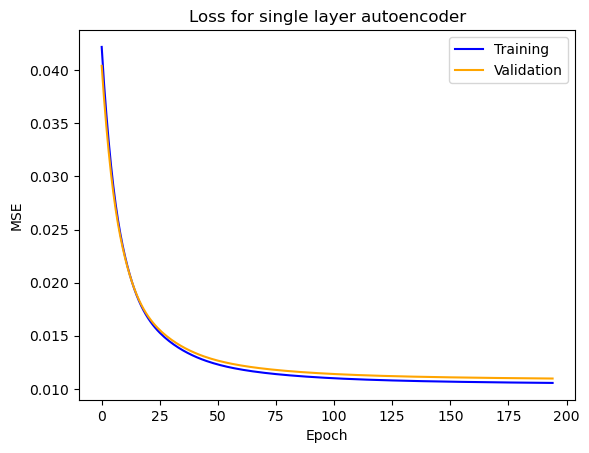

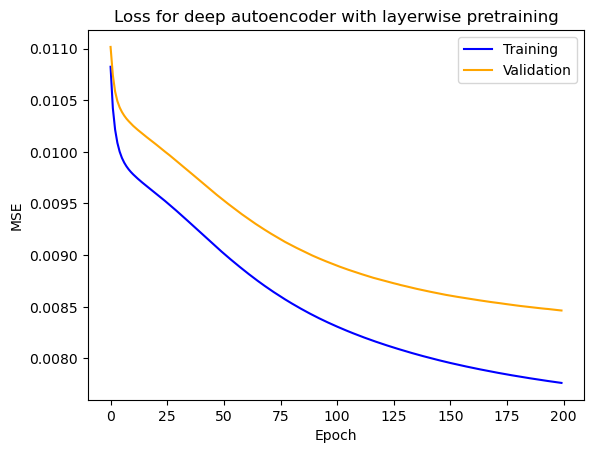

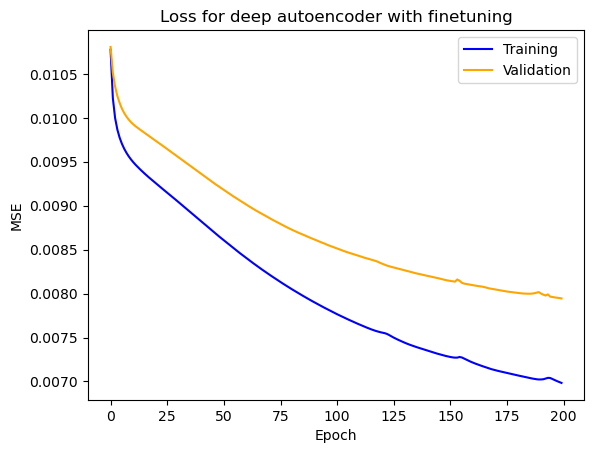

In [26]:
plot_loss(tr_loss_list_single[5:], val_loss_list_single[5:],
          "Loss for single layer autoencoder")
plot_loss(tr_loss_list_deep, val_loss_list_deep,
          "Loss for deep autoencoder with layerwise pretraining")
plot_loss(tr_loss_list_ft, val_loss_list_ft,
          "Loss for deep autoencoder with finetuning")

MSE values on the validation set for the three models. As one would expect, the deep autoencoders achieve better loss than the single layer one. Additionally, finetuning does help, as it is able to further reduce the loss.

In [27]:
model.eval()
deep_model.eval()
deep_model_ft.eval()
print("Loss on validation set:")
with torch.no_grad():
  predictions = model(val_data_noisy)
  loss = criterion(predictions, val_target).data
  print(f"\tSingle layer autoencoder loss: {loss:.4f}")

  deep_predictions = deep_model(val_data_noisy)
  loss = criterion(deep_predictions, val_target).data
  print(f"\tDeep autoencoder with layerwise pretraining Loss: {loss:.4f}")
  
  deep_ft_predictions = deep_model_ft(val_data_noisy)
  loss = criterion(deep_ft_predictions, val_target).data
  print(f"\tDeep autoencoder with finetuning Loss: {loss:.4f}")

Loss on validation set:
	Single layer autoencoder loss: 0.0110
	Deep autoencoder with layerwise pretraining Loss: 0.0085
	Deep autoencoder with finetuning Loss: 0.0079


MSE values on the test set for the three models. The same observations made for the validation set hold here as well.

In [28]:
model.eval()
deep_model.eval()
deep_model_ft.eval()
print("Loss on test set:")
with torch.no_grad():
  test_predictions = model(ts_data_noisy)
  loss = criterion(test_predictions, ts_target).data
  print(f"\tSingle layer autoencoder loss: {loss:.4f}")

  test_deep_predictions = deep_model(ts_data_noisy)
  loss = criterion(test_deep_predictions, ts_target).data
  print(f"\tDeep autoencoder with layerwise pretraining Loss: {loss:.4f}")
  
  test_deep_ft_predictions = deep_model_ft(ts_data_noisy)
  loss = criterion(test_deep_ft_predictions, ts_target).data
  print(f"\tDeep autoencoder with finetuning Loss: {loss:.4f}")

Loss on test set:
	Single layer autoencoder loss: 0.0105
	Deep autoencoder with layerwise pretraining Loss: 0.0081
	Deep autoencoder with finetuning Loss: 0.0076


## Experiments
All experiments will be done using the test set. This goes for both the model testing and the experiments on latent space interpolation.

### Model testing

Comparisons between the original image, the noisy version, and the images reconstructed by the three models. One example for each digit is shown here.<br>
Overall it is possible to see that the single layer and deep autoencoders return similar images, generally managing to denoise the original image quite well. Some imperfections are still present though, for example slightly changing the shape of the digit. The deep autoencoder manages to more accurately recreate the original image compared to the single layer one. With finetuning results are further improved, and the digits appear sharper, more akin to the original non noisy versions.<br>

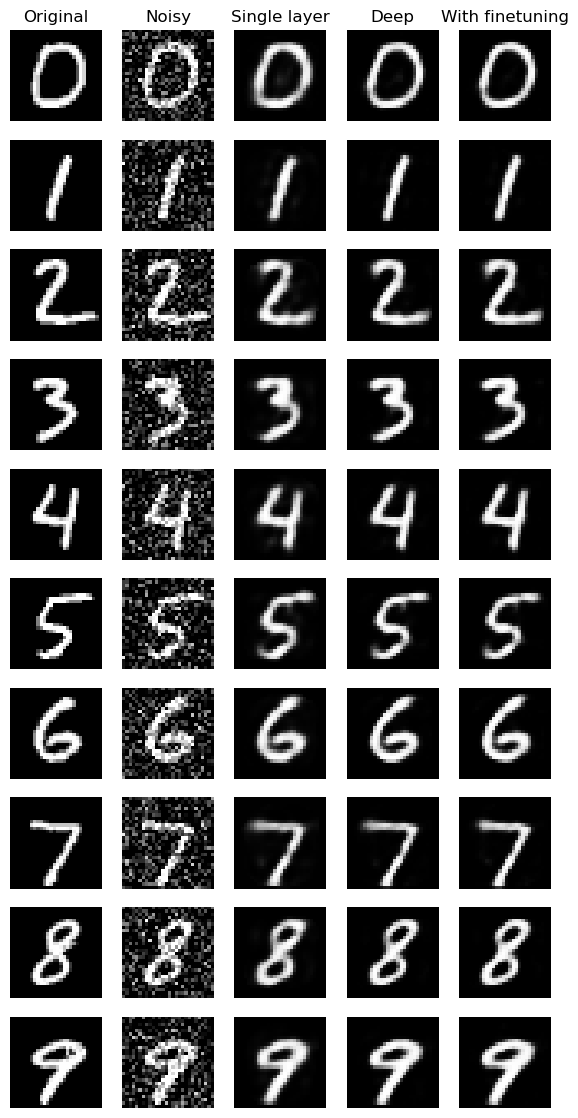

In [29]:
data_list = [ts_mnist, ts_data_noisy.cpu(), test_predictions.cpu(), 
             test_deep_predictions.cpu(), test_deep_ft_predictions.cpu()]
label_list = ["Original", "Noisy", "Single layer", "Deep",
              "With finetuning"]

indices = [10, 5, 1, 30, 27, 2798, 1831, 0, 110, 9]
plot_comparison(data_list, label_list, indices, figsize=(7, 14))

Something that might be interesting to check is how the three autoencoders behave when the input image has varying amounts of noise.<br>
It is easy to see that the single layer autoencoder actually has trouble reconstructing even an image without noise, and only really works properly at the same level of noise used in training. The deep autoencoder without finetuning manages to get slightly better results, but still has trouble as soon as the amount of noise is increased. Finally, the version with finetuning actually manages to get decent results even while increasing noise further than what was used while training the model. With too much noise, though, even this model has trouble reconstructing the original image, and quality of the results starts depending on how much the noise distorts the image.

Loss on validation data with added noise at scale 0:
	Single layer autoencoder loss: 0.0330
	Deep autoencoder with layerwise pretraining Loss: 0.0128
	Deep autoencoder with finetuning Loss: 0.0057


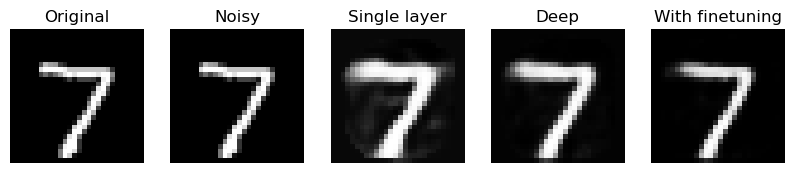

--------------------------------------------------
Loss on validation data with added noise at scale 0.3:
	Single layer autoencoder loss: 0.0105
	Deep autoencoder with layerwise pretraining Loss: 0.0081
	Deep autoencoder with finetuning Loss: 0.0076


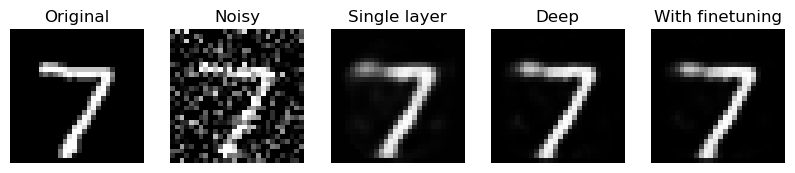

--------------------------------------------------
Loss on validation data with added noise at scale 0.5:
	Single layer autoencoder loss: 0.0319
	Deep autoencoder with layerwise pretraining Loss: 0.0240
	Deep autoencoder with finetuning Loss: 0.0155


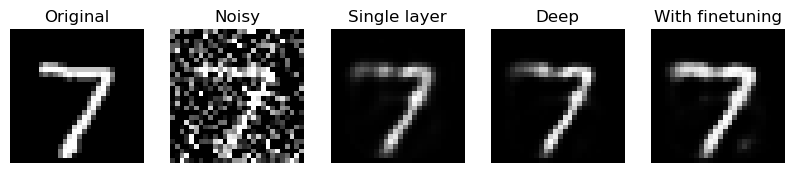

--------------------------------------------------
Loss on validation data with added noise at scale 0.7:
	Single layer autoencoder loss: 0.0644
	Deep autoencoder with layerwise pretraining Loss: 0.0506
	Deep autoencoder with finetuning Loss: 0.0277


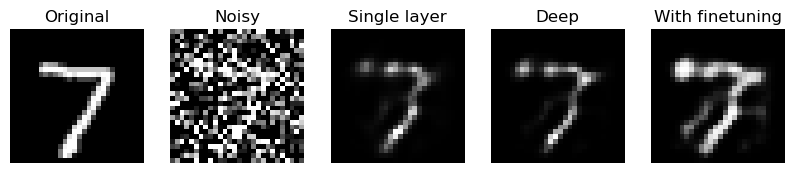

--------------------------------------------------


In [56]:
model.eval()
deep_model.eval()
deep_model_ft.eval()
scales = [0, 0.3, 0.5, 0.7]
index = 0
for scale in scales:
  ts_data_noisy_tmp = (ts_mnist + scale * 
                        torch.randn(ts_mnist.shape)).to(device)
  ts_data_noisy_tmp = torch.clip(ts_data_noisy_tmp, 0, 1)
  print(f"Loss on validation data with added noise at scale {scale}:")
  with torch.no_grad():
    predictions = model(ts_data_noisy_tmp)
    loss = criterion(predictions, ts_mnist.to(device)).data
    print(f"\tSingle layer autoencoder loss: {loss:.4f}")

    deep_predictions = deep_model(ts_data_noisy_tmp)
    loss = criterion(deep_predictions, ts_mnist.to(device)).data
    print(f"\tDeep autoencoder with layerwise pretraining Loss: {loss:.4f}")
    
    deep_ft_predictions = deep_model_ft(ts_data_noisy_tmp)
    loss = criterion(deep_ft_predictions, ts_mnist.to(device)).data
    print(f"\tDeep autoencoder with finetuning Loss: {loss:.4f}")

  data_list = [ts_mnist.cpu(), ts_data_noisy_tmp.cpu(), predictions.cpu(), 
              deep_predictions.cpu(), deep_ft_predictions.cpu()]
  label_list = ["Original", "Noisy", "Single layer", "Deep",
                "With finetuning"]
  plot_comparison(data_list, label_list, [index], figsize=(10, 3))
  print("-"*50)

### Latent space interpolation experiments
The experiments in this section will be done only using the deep autoencoder with finetuning, as it gives the encoding of highest quality among the ones obtained, as one would expect.<br>
The data used is still the test set, but this time we use the original data without any added noise.

#### Utility functions for interpolation
Utility function to quickly interpolate two tensors.

In [33]:
def interpolate(data1: torch.tensor, data2: torch.tensor, alpha: int = 0.5) -> torch.tensor:
    """function to interpolate two tensors

    Parameters
    ----------
    data1 : torch.tensor
        first tensor to interpolate
    data2 : torch.tensor
        second tensor to interpolate
    alpha : int, optional
        parameter deciding how to weigh each tensor. 
        More specifically the formula used is (1 - alpha) * data1 + alpha * data2,
        by default 0.5

    Returns
    -------
    torch.tensor
        the interpolation of the two input tensors

    Raises
    ------
    ValueError
    """
    if data1.shape != data2.shape:
        raise ValueError("Both tensors must be the same shape")
    if alpha < 0 or alpha > 1:
        raise ValueError("Parameter a must be in range [0, 1]")
    with torch.no_grad():
        interpolation = (1 - alpha) * data1 + alpha * data2
    return interpolation

Utility function to quickly plot interpolations at varying alphas. Also handles encoding and decoding of input data.

In [79]:
def plot_interpolations(model: nn.Module, data1: torch.tensor, data2: torch.tensor, 
                        alphas: list[int] = [0, 0.25, 0.4, 0.5, 0.6, 0.75, 1]) -> None:
    """function to plot the decoding of the given model for the interpolation of the encoding of two tensors.
    This is done for various alphas, given in input. Both encoding and decoding is handled inside the function,
    requiring the input to be the original image itself, not its encoding

    Parameters
    ----------
    model : nn.Module
        autoencoder to use for encoding and decoding
    data1 : torch.tensor
        first tensor to interpolate
    data2 : torch.tensor
        second tensor to interpolate
    alphas : list[int], optional
        list of alpha values to use, by default [0, 0.25, 0.4, 0.5, 0.6, 0.75, 1]
    """
    
    with torch.no_grad():
        
        # encode the data
        data = torch.stack([data1, data2])
        encoding = model.encode(data)

        # add the original image to the list that will be plotted later
        ls_interpolations = [data1.cpu()]

        # interpolate using the various values of alpha
        for alpha in alphas:
            # interpolate...
            interpolation = interpolate(encoding[0], encoding[1], alpha)
            interpolation = torch.reshape(interpolation, (1, 50))

            # ... and then decode the interpolation
            decoded_test = model.decode(interpolation).cpu()
            decoded_test = torch.reshape(decoded_test, (28, 28))

            # append to list of images to be plotted
            ls_interpolations.append(decoded_test)
        
        # add the original image to the list that will be plotted later
        ls_interpolations.append(data2.cpu())

    labels = ["original",] + alphas + ["original",]
    plot_list(np.arange(0, len(labels)), ls_interpolations, labels)

#### Interpolating same digits
The first experiments will be done by trying to interpolate the encodings of two samples corresponding to the same digit.

In this first example two samples for 8 are interpolated. The two digits are very similar. From this first example we can see that the interpolation gives the results that one might expect, being a blend of sort of the two original images. The alpha parameter, as expected, controls how much the interpolation is pushed towards either sample. 

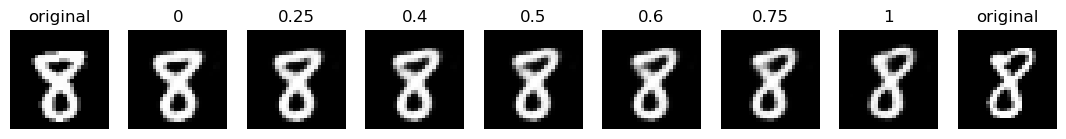

In [80]:
index1 = 128
index2 = 134
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

A similar example to the previous one, using two samples for 3 instead of 8. The results are of similar quality, and the same behaviour is observed. 

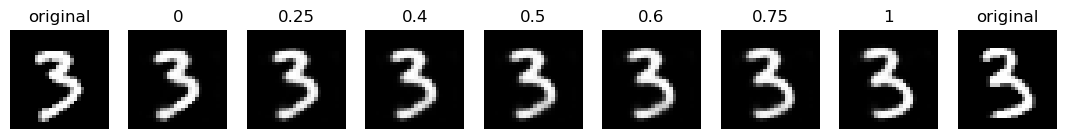

In [36]:
index1 = 30
index2 = 32
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

This test strays from the two preceding ones, as the digit is the same, but the way they are written is quite different. While the interpolation is still a mix of the original samples, the results for values of alpha near 0.5 are less "clean" than what was seen in the previous examples. It is interesting to note that even when the interpolation is weighted slightly more towards the digit on the left, the shape of the 9 is still more similar to the one on the right. This might be because the left 9 has the more common shape, so when the decoder gets in input something recognized as a 9, it tends to recontruct it that way.

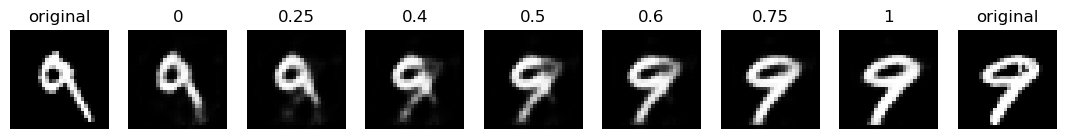

In [37]:
index1 = 7
index2 = 9
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

Another example similar to the previous one, using two samples for 4. Despite the two digits looking different, it does not seem like one is more dominant than the other, unlike what was observed in the previous example.

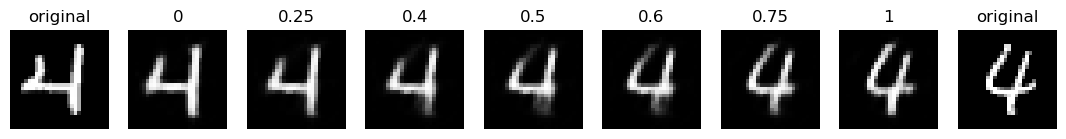

In [82]:
index1 = 103
index2 = 109
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

Once again an example with the same digit with two different shapes. The image on the right seems to be slightly more dominant in this case. One additional thing to note is that the interpolation also changes in thickness of the line depending on which sample is weighted more, so with interpolation it is possible to mix more than just the shapes of the digits.

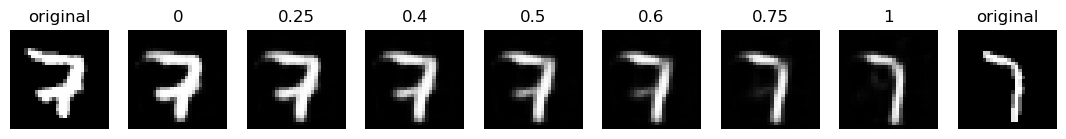

In [39]:
index1 = 133
index2 = 122
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

When the digits have wildly different shapes the result of the interpolation can lead to weird behaviour when decoded. Here for example the original digits are mirrored, leading to an awkard x shape when weighted equally or almost equally. Nonetheless, the point where they intersect is more defined compared to the spots in the corners.

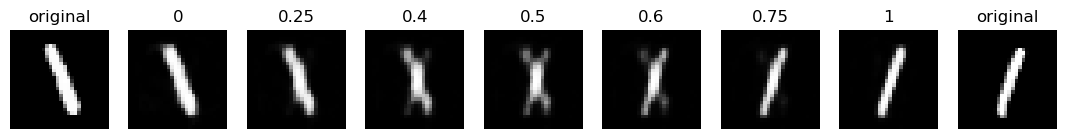

In [40]:
index1 = 46
index2 = 5
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

Similar to the previous example, the interpolation leads to the decoder outputting a broken mix of the starting samples. Just like before, the parts that are similar in both images appear brighter, in this case the bottom of the digits.

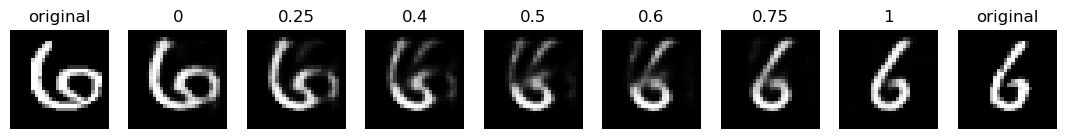

In [41]:
index1 = 54
index2 = 50
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

#### Interpolating different digits
This section will contain experiments regarding interpolation between the encodings of different digits.

The first example is done using an 8 and a 3. The example shows that the interpolation tends to skew towards an 8 when decoded. It is possible that this is because an 8 can basically fully contain a 3, and this might be a characteristic that is also present in the latent space in some way.

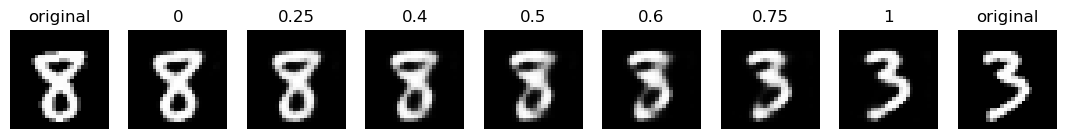

In [43]:
index1 = 128
index2 = 30
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

Using a 5 and a 6 gives results heavily skewed towards a 6. In this particular case though the 5 has a shape very similar to a 6, being almost closed on the bottom.

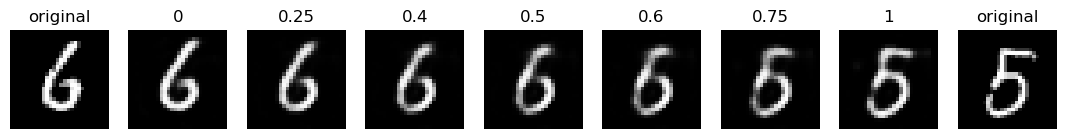

In [44]:
index1 = 50
index2 = 45
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

Using a different sample for 5 gives more even results compared to the previous example, but the decoder still tends to rebuild shapes more resembling a 6.

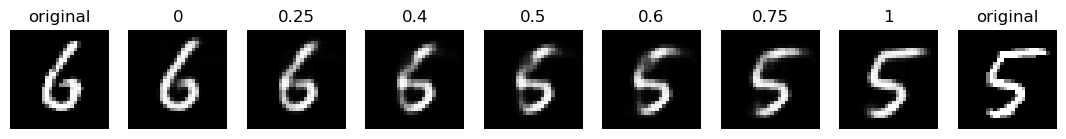

In [84]:
index1 = 50
index2 = 2798
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

Interpolating a 0 and a 1 is a fun example, as it returns a barred 0, even if a bit blurry.

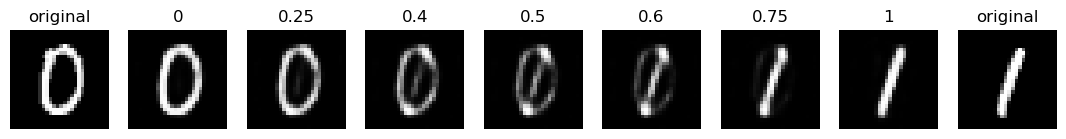

In [42]:
index1 = 136
index2 = 5
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

More often than not interpolating the encoding of two different digits leads to rather bad results. The reconstructed images are generally noisy, blurry, and do not really resemble any digit. In this first example one could vaguely see an eight when alpha is 0.4, but it is far from the quality of the results seen in previous examples.

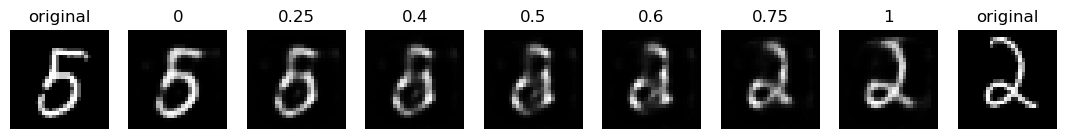

In [45]:
index1 = 45
index2 = 47
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

Another example where the interpolation gives bad results. One thing that is only kinda noticeable here is that with alpha = 0.5 the resulting image has peaks of brightness where the two original images overlap. This is something that was already observable in all previous examples, even when using the same digit, but the effect is more intense when the digits have thicker lines.

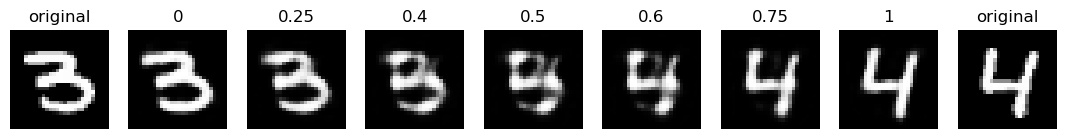

In [46]:
index1 = 51
index2 = 56
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

The phenomenon describes in the previous example is even more apparent when using a 1 as one of the original samples.

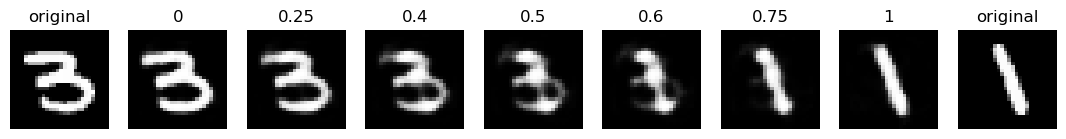

In [47]:
index1 = 51
index2 = 46
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

One more example highlighting this property.

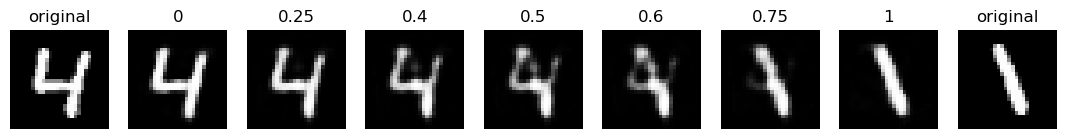

In [48]:
index1 = 56
index2 = 46
plot_interpolations(deep_model_ft, ts_mnist[index1].to(device), ts_mnist[index2].to(device))

#### General observations on latent space interpolation
TODO

## Final remarks
TODO

## Extras
Some extra analysis that was not required by the assignment.<br>
First of all encode the whole test set.

In [ ]:
deep_model_ft.eval()
with torch.no_grad():
    encoded_test = deep_model_ft.encode(ts_mnist.to(device))

### Average digits
An interesting experiment is computing the average encoding of each digit and then decoding it to see what the "average" digit looks like.

In [49]:
def plot_average_digits(model: nn.Module, data: torch.tensor, labels: torch.tensor) -> None:
  """utility function to compute and plot the average digits

  Parameters
  ----------
  model : nn.Module
      autoencoder to use for decoding
  data : torch.tensor
      data to use for computing average digits
  labels : torch.tensor
      labels to identify which digit is represented by each element of data
  """
  fig, axes = plt.subplots(1, 10, figsize=(15, 3))
  for i in range(10):
    ax = axes[i]

    # get only data corresponding to currently considered digit
    filtered_data = data[torch.where(labels == i)]
    # compute average encoding
    avg_data = torch.mean(filtered_data, 0)
    
    with torch.no_grad():
      # decode average encoding
      avg_data = torch.reshape(avg_data, (1, 50))
      decoded_data = model.decode(avg_data)

    ax.imshow(decoded_data[0].cpu(), cmap="gray")
    ax.axis("off")

  plt.show()

The results are what one might expect. Despite being a little blurry each digit corresponds to how each digit is most often written.

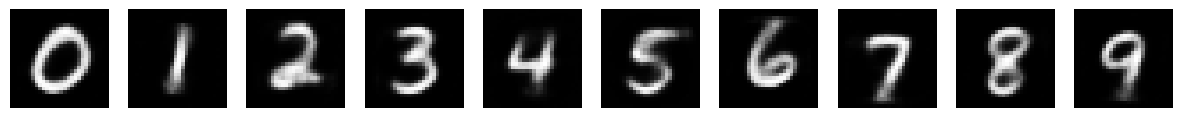

In [50]:
plot_average_digits(deep_model_ft, encoded_test, ts_mnist_labels)

### Adding noise to average digits

After obtaining the average encoding of each digit, it might be interesting to see how adding some noise to it changes the reconstructed image.

In [51]:
def plot_noisy_average_digits(model: nn.Module, data: torch.tensor, 
                              labels: torch.tensor, scale: int = 0.1):
  """utility function to compute and plot the average digits with some added noise

  Parameters
  ----------
  model : nn.Module
      autoencoder to use for decoding
  data : torch.tensor
      data to use for computing average digits
  labels : torch.tensor
      labels to identify which digit is represented by each element of data
  scale : int, optional
      the scale of the added random noise, by default 0.1
  """
  fig, axes = plt.subplots(1, 10, figsize=(15, 3))
  for i in range(10):
    ax = axes[i]

    # get only data corresponding to currently considered digit
    filtered_data = data[torch.where(labels == i)]
    
    # compute average encoding
    avg_data = torch.mean(filtered_data, 0).to(device)

    # add noise to encoding
    avg_data += scale * torch.randn(avg_data.shape).to(device)

    with torch.no_grad():
      # decode average encoding
      avg_data = torch.reshape(avg_data, (1, 50))
      decoded_data = model.decode(avg_data)

    ax.imshow(decoded_data[0].cpu(), cmap="gray")
    ax.axis("off")
  plt.show()

Results are not too interesting unfortunately, as the digits only become generally more wobbly and unstable depending on how much noise was added to the average digit encoding.

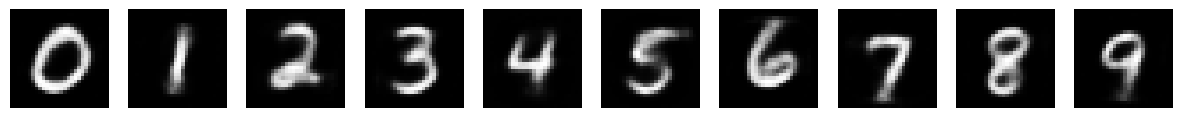

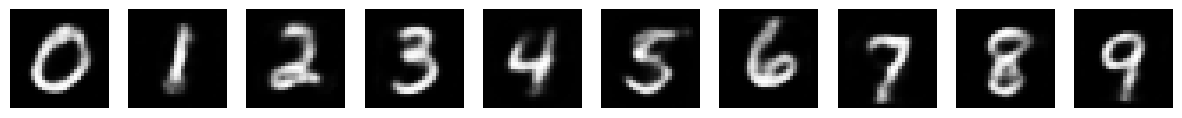

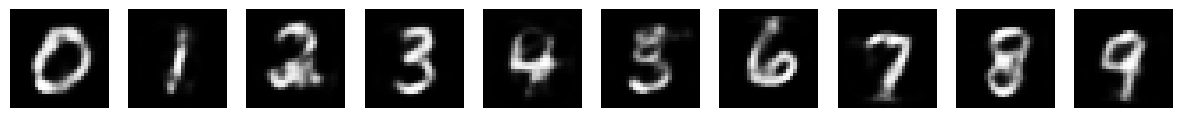

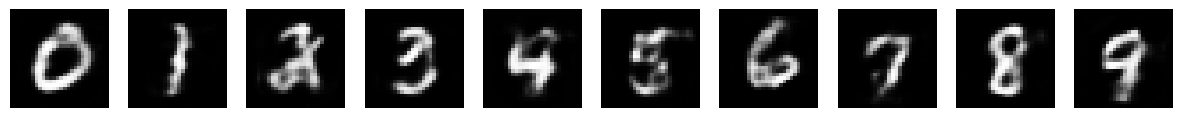

In [85]:
scales = [0.25, 0.5, 0.75, 1]

for scale in scales:
    plot_noisy_average_digits(model=deep_model_ft, data=encoded_test, labels=ts_mnist_labels, scale=scale)

### Latent space encoding visualization
The autoencoder encodes digits in a 50-dimensional space, which is not possible to visualize. Workarounds exist though, as there are ways to get a projection of highly dimensional data in a 2D space so that it can be visualized. With one of these methods we can get a visualization of the encoding of the test set.

In [53]:
import pandas
import plotly.express as px


The first thing that we can clearly see is that the digits are all quite separate from each other, forming very distinct clusters. Something that might be a bit harder to notice though is that some digits are clos to each other in ways that make sense given their shapes. Specifically, 3, 5 and 8 are all close to each other, 4 and 9 are close, 7 and 9. These are the most compact groups, with two less relevant groups being 5 and 6, 0 and 6.<br>
These observations also shed some light on why certain pairs of digits give better results when interpolated,

In [54]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_test.cpu())
fig = px.scatter(tsne_results, x=0, y=1,
                 color=ts_mnist_labels,
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()